In [1]:
import torch, zipfile, torchvision, time, os, copy, random, timm, shutil
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

RANDOM_SEED = 2

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
Num_class = 4

with zipfile.ZipFile('/kaggle/input/dental-radiography-more-balanced-subset/Dental_Data.zip', 'r') as zip_ref:
        # Extract all contents
        zip_ref.extractall('./')

shutil.rmtree('/kaggle/working/test/Normal')

if Num_class == 4:
    shutil.rmtree('/kaggle/working/train/Normal')
    shutil.rmtree('/kaggle/working/valid/Normal')

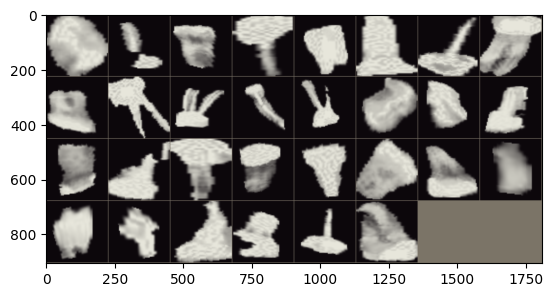

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.CenterCrop((470,470)),
        transforms.RandomRotation(10,),
        transforms.RandomPerspective(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = './'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}

dataloaders_test = {'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=24,
                                             shuffle=False, num_workers=0)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.savefig('Augmented_data_train.pdf', bbox_inches = 'tight')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

In [4]:
model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
num_ftrs = model_ft.head.in_features

#model_ft = models.resnet50(pretrained=True) #wide_resnet101_2
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, Num_class)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
             
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3) 

Epoch 0/2
----------
train Loss: 0.6639 Acc: 0.7715
valid Loss: 0.3368 Acc: 0.8796

Epoch 1/2
----------
train Loss: 0.2762 Acc: 0.9027
valid Loss: 0.2647 Acc: 0.9019

Epoch 2/2
----------
train Loss: 0.1956 Acc: 0.9319
valid Loss: 0.2238 Acc: 0.9315

Training complete in 15m 22s
Best val Acc: 0.931481


In [7]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders_test['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output = output[:,0:4] # consider 4 classes

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

Test Accuracy: 0.9104803493449781


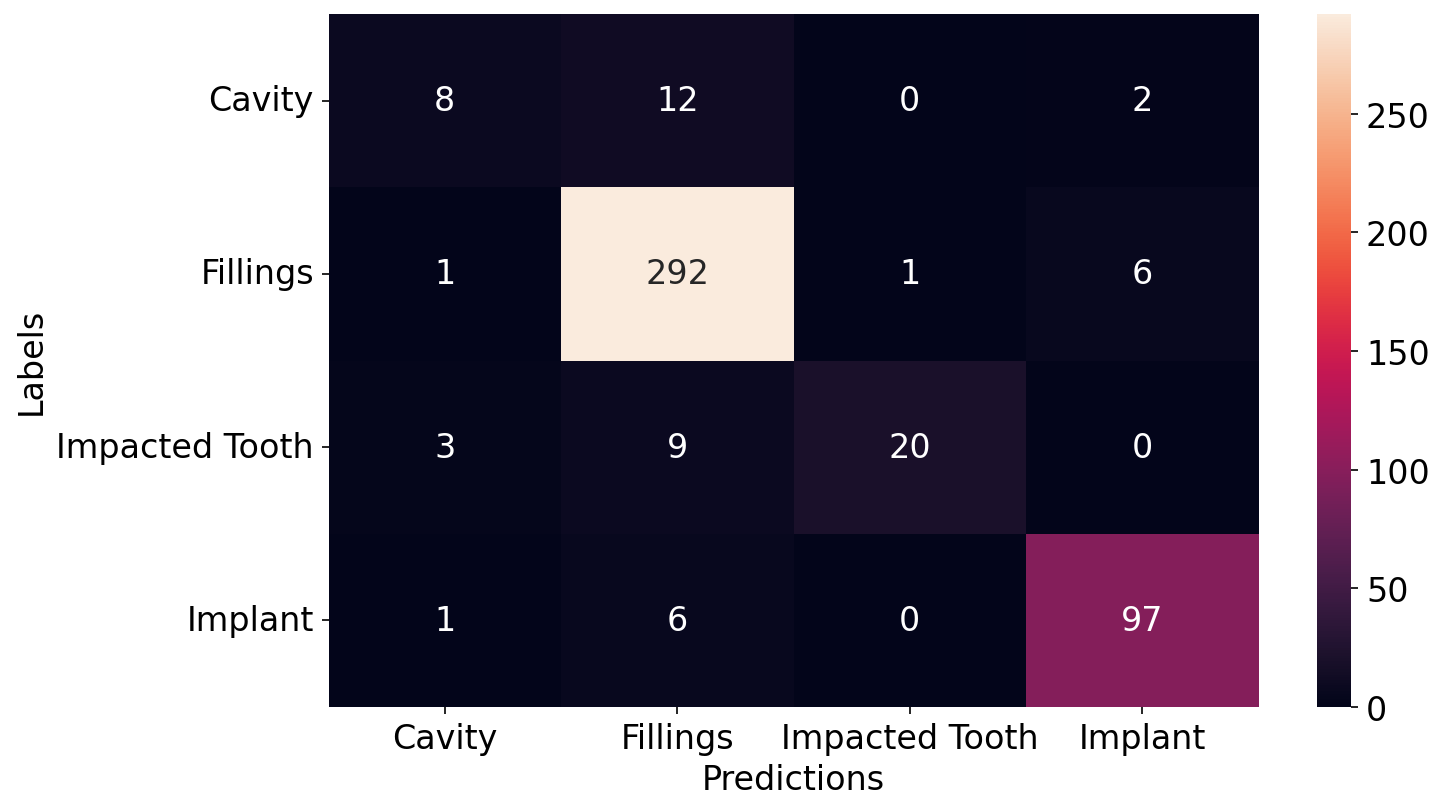

In [8]:
test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

classes = ('Cavity','Fillings','Impacted Tooth','Implant') # ,'Normal' 
# We omitted the normal, as it is background
    
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (10,6),dpi=150)
plt.rcParams['font.size'] = '16'
fig = sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show(fig)

fig.figure.savefig('Confusion_test.pdf', bbox_inches = 'tight')